In [1]:
from scipy.special import ellipkinc as EllipticF
#from scipy import ndimage, misc
import math
import numpy as np
from tqdm import tqdm
import matplotlib as plt


In [97]:
!pip install jaxlib

ERROR: Could not find a version that satisfies the requirement jaxlib (from versions: none)
ERROR: No matching distribution found for jaxlib


In [12]:
Lx = 100 #Grid size x-dimension
Ly =100#Grid size y-dimension
Nx = 256# Number of discretization points in x-direction
Ny = 256  # Number of discretization points in y-direction
T_End = 50
tt=50 #fps
dt=0.1
N_ITERATIONS = int(T_End / dt)

######
loc = 0
res_scale=0.15
input_scale=0.75
n_res = Nx**2
nn = input_dim = 32
scale1 = input_scale / (2*np.sqrt(input_dim))
#scale2 = res_scale / np.sqrt(n_res)
parallel_runs = 1
input_to_defect_ratio = 64
mm = int(n_res/input_to_defect_ratio)

#Meshgrid of real an freq spacies
x, y = np.meshgrid(np.arange(Nx) * Lx/Nx, np.arange(Ny) * Ly/Ny) #x-Array
kx, ky = np.meshgrid(np.fft.fftfreq(Nx,Lx/(Nx*2.0*np.pi)), np.fft.fftfreq(Ny,Ly/(Ny*2.0*np.pi)))
ksq = kx**2 + ky**2
q = np.zeros([parallel_runs,int(np.sqrt(n_res)), int(np.sqrt(n_res))])

#Matricies
scale_matrix = np.ones(shape=(int(np.sqrt(input_to_defect_ratio)), int(np.sqrt(input_to_defect_ratio)), 1)) #/np.sqrt(self.input_to_defect_ratio)
w1r = np.random.normal(loc, scale1, size=(mm,nn)) + np.random.normal(loc, scale1, size=(mm,nn)) * 1j
w1l = np.random.normal(loc, scale1, size=(mm,nn)) + np.random.normal(loc, scale1, size=(mm,nn)) * 1j


In [13]:
A_hat = np.zeros([parallel_runs,int(np.sqrt(n_res)), int(np.sqrt(n_res))],dtype=complex)
def LC_state(E_in, A, N_n):
        parallel_runs = E_in.shape[1]
        ne = 1.5
        no = 1.7
        lamda = 0.532
        L = 10 # sample thickness is 10mkm
        k = 2*np.pi/lamda
        A = np.tile(A, [1, 1, int(parallel_runs/A.shape[2])])
        nx = A.real
        ny = A.imag
        psi = np.angle(A)
        a = (no**2-ne**2)*(nx**2+ny**2)
        delta = k*(ne*no*np.sqrt(a+2*ne**2+a*math.cos(2*k*L)/(a+ne**2))*EllipticF(
            k*L, a/(a+ne**2))/(k*np.sqrt(a+2*ne**2+a*(math.cos(k*L)))) - no*L)
        
        # First Pass Through W1
        P1_1 = w1r@E_in
        P1_2 = w1l@E_in
        P1_1 = P1_1.reshape(int(np.sqrt(mm)), int(np.sqrt(mm)), parallel_runs)
        P1_2 = P1_2.reshape(int(np.sqrt(mm)), int(np.sqrt(mm)), parallel_runs)
        
        
        P1_1 = np.kron(P1_1, scale_matrix)
        P1_2 = np.kron(P1_2, scale_matrix)
        
        P1_1 = np.transpose(P1_1, (2,0,1))
        P1_2 = np.transpose(P1_2, (2,0,1))

        
        # Second Pass Through LC
        #P2_1 = np.exp(1j*delta/2)*(P1_1*np.cos(delta/2)+1j*P1_2*np.sin(delta/2)*np.exp(-1j*2*psi))
        #P2_2 = np.exp(1j*delta/2)*(P1_2*np.cos(delta/2)+1j*P1_1*np.sin(delta/2)*np.exp(1j*2*psi))

        
        myu = np.power(np.abs(P1_1), 2) + np.power(np.abs(P1_2), 2)
        A_t = np.transpose(A, (2,0,1))
        N_n1 = N_n
        for k in range(parallel_runs):
            
            A_hat[k,:,:] = np.fft.fft2(A_t[k,:,:])  

            q[k,:,:] = myu[k,:,:] - ksq**2
            coef1=((1+q[k,:,:]*dt)*np.exp(q[k,:,:]*dt)-1-2*dt*q[k,:,:])/(dt*q[k,:,:]**2)
            coef2=(-np.exp(q[k,:,:]*dt)+1+dt*q[k,:,:])/(dt*q[k,:,:]**2)
            
            N_n = -np.fft.fft2(np.fft.ifft2(A_hat[k,:,:])*np.abs(np.fft.ifft2(A_hat[k,:,:]))**2)

            
            A_hat[k,:,:] = A_hat[k,:,:]*np.exp(q[k,:,:]*dt) + N_n*coef1 + N_n1*coef2
        
            A_t[k,:,:] = np.fft.ifft2(A_hat[k,:,:])
        
        N_nt = N_n
        A_t_t = np.transpose(A_t, (1,2,0))
        return (A_t_t, N_nt)

In [14]:
A_0 = np.random.normal(0, 1, size=(int(np.sqrt(n_res)), int(np.sqrt(n_res)), parallel_runs))*0.05+ np.random.normal(
                 0, 1, size=(int(np.sqrt(n_res)), int(np.sqrt(n_res)), parallel_runs)) * 0.05j
#N_n_0 = np.zeros([int(np.sqrt(n_res)), int(np.sqrt(n_res)),parallel_runs])
A_0_t = np.transpose(A_0, (2,0,1))

A_0_hat = np.fft.fft2(A_0_t[0,:,:])
N_n_0 = np.fft.fft2(np.fft.ifft2(A_0_hat)*np.abs(np.fft.ifft2(A_0_hat))**2)

A_all = np.zeros([N_ITERATIONS,int(np.sqrt(n_res)), int(np.sqrt(n_res)),parallel_runs],dtype=complex)
A_in = np.zeros([N_ITERATIONS,int(np.sqrt(n_res)), int(np.sqrt(n_res))])

A = A_0
N_n = N_n_0
for index in tqdm(range(N_ITERATIONS)):
    E_in = np.random.normal(0, 1, size=(nn, 1)) + np.random.normal(0, 1, size=(nn, 1)) * 1j
    A,  N_n = LC_state(E_in, A, N_n)
    A_all[index,:,:,:] = A[:,:,:]
    A_in[index,:,:] = A_all[index,:,:,0].real*A_all[index,:,:,0].imag
A.shape
#A = np.transpose(A, (1,2,0))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.67it/s]


(256, 256, 1)

Text(0.5, 0, '|A|')

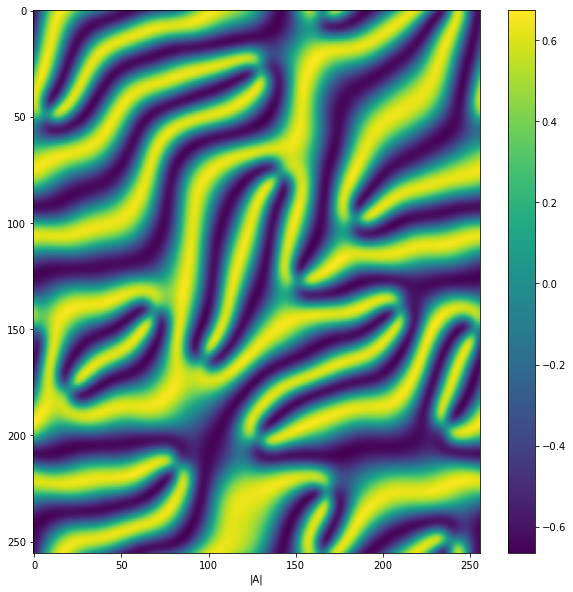

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure( figsize=(10,10))
#plt.imshow(A_in[1,1,290,:,:], cmap=plt.get_cmap('twilight'), aspect="auto")
im = plt.imshow(A_in[499,:,:], aspect="auto")
plt.colorbar(im)
plt.xlabel('|A|')